# Part 5: Hydrogen-like Radial Equation (Stretch Goal)

## The 3D Hydrogen Atom → 1D Radial Problem

The hydrogen atom is a 3D problem, but using spherical symmetry we can separate it:

$$\psi(r,\theta,\phi) = R(r) \cdot Y_{lm}(\theta,\phi)$$

The radial part satisfies a **1D-like equation**!

### The Radial Schrödinger Equation

With substitution $u(r) = r \cdot R(r)$:

$$-\frac{\hbar^2}{2m}\frac{d^2u}{dr^2} + \left[V(r) + \frac{\hbar^2 l(l+1)}{2mr^2}\right]u = Eu$$

This looks like 1D Schrödinger with **effective potential**:
$$V_{eff}(r) = V(r) + \frac{\hbar^2 l(l+1)}{2mr^2}$$

### Terms Explained
- **Coulomb**: $V(r) = -\frac{e^2}{4\pi\epsilon_0 r} = -\frac{Z}{r}$ (atomic units)
- **Centrifugal barrier**: $\frac{l(l+1)}{2r^2}$ — pushes particle away from nucleus for $l > 0$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 5]

# Atomic units: ℏ = m_e = e = 4πε₀ = 1
# Energy in Hartree (1 Ha = 27.2 eV)
# Length in Bohr radii (a₀ = 0.529 Å)

In [3]:
def build_kinetic(N, dr):
    """Kinetic energy matrix in atomic units (ℏ = m = 1)"""
    coeff = -1.0 / (2 * dr**2)
    return coeff * (np.diag(-2*np.ones(N)) + 
                    np.diag(np.ones(N-1), 1) + 
                    np.diag(np.ones(N-1), -1))

## Defining the Potentials

### Coulomb Potential
Attraction between electron (-e) and nucleus (+Ze):
$$V_{Coulomb}(r) = -\frac{Z}{r}$$

### Centrifugal Barrier
Angular momentum creates outward "pressure":
$$V_{centrifugal}(r) = \frac{l(l+1)}{2r^2}$$

For l=0 (s-orbitals): no barrier — electron can be at nucleus
For l≥1 (p, d, ...): barrier prevents electron from reaching nucleus

In [4]:
def coulomb_potential(r, Z=1):
    """
    Coulomb potential: V(r) = -Z/r
    
    Parameters:
    -----------
    r : ndarray - Radial grid (must be r > 0)
    Z : float - Nuclear charge (Z=1 for hydrogen)
    """
    return -Z / r

def centrifugal_barrier(r, l):
    """
    Centrifugal barrier: l(l+1)/(2r²)
    
    Parameters:
    -----------
    r : ndarray - Radial grid
    l : int - Angular momentum quantum number (0,1,2,...)
    """
    return l * (l + 1) / (2 * r**2)

def effective_potential(r, l, Z=1):
    """Combined Coulomb + centrifugal"""
    return coulomb_potential(r, Z) + centrifugal_barrier(r, l)

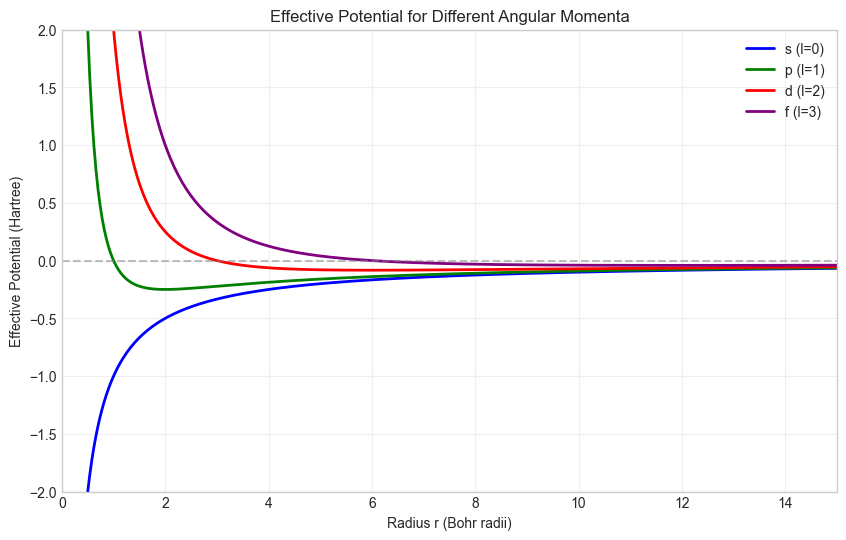

In [5]:
# Visualize effective potentials for different l
r_plot = np.linspace(0.1, 20, 500)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple']
labels = ['s (l=0)', 'p (l=1)', 'd (l=2)', 'f (l=3)']

for l, (color, label) in enumerate(zip(colors, labels)):
    V_eff = effective_potential(r_plot, l)
    ax.plot(r_plot, V_eff, color=color, lw=2, label=label)

ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Radius r (Bohr radii)')
ax.set_ylabel('Effective Potential (Hartree)')
ax.set_title('Effective Potential for Different Angular Momenta')
ax.set_xlim(0, 15)
ax.set_ylim(-2, 2)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [7]:
# ============================================================
# SOLVE FOR HYDROGEN RADIAL WAVEFUNCTIONS
# ============================================================

# Radial grid (avoid r=0 singularity)
r_min = 0.01
r_max = 50.0
N = 1000

r = np.linspace(r_min, r_max, N)
dr = r[1] - r[0]

# Build kinetic matrix
T = build_kinetic(N, dr)

# Solve for s, p, d orbitals
results = {}
orbital_names = {0: 's', 1: 'p', 2: 'd'}

print("Solving radial Schrödinger equation for hydrogen...\n")

for l in [0, 1, 2]:
    # Effective potential for this l
    V_eff = effective_potential(r, l, Z=1)
    
    # Build Hamiltonian
    H = T + np.diag(V_eff)
    
    # Solve eigenvalue problem
    energies, u = linalg.eigh(H)
    
    # Select bound states (E < 0)
    bound_mask = energies < 0
    bound_E = energies[bound_mask]
    bound_u = u[:, bound_mask]
    
    # Normalize: ∫|u|²dr = 1
    for i in range(bound_u.shape[1]):
        norm = np.sqrt(np.trapezoid(bound_u[:, i]**2, r))
        bound_u[:, i] /= norm
        if bound_u[5, i] < 0:  # Fix sign convention
            bound_u[:, i] *= -1
    
    results[l] = {'energies': bound_E, 'u': bound_u}
    
    # Compare with exact: E_n = -1/(2n²)
    print(f"l = {l} ({orbital_names[l]}-orbitals):")
    for i, E in enumerate(bound_E[:3]):
        n = i + l + 1  # Principal quantum number
        E_exact = -0.5 / n**2
        error = 100 * abs(E - E_exact) / abs(E_exact)
        print(f"  {n}{orbital_names[l]}: E = {E:.4f} Ha (exact: {E_exact:.4f}, error: {error:.2f}%)")
    print()

Solving radial Schrödinger equation for hydrogen...

l = 0 (s-orbitals):
  1s: E = -0.7382 Ha (exact: -0.5000, error: 47.64%)
  2s: E = -0.1501 Ha (exact: -0.1250, error: 20.12%)
  3s: E = -0.0626 Ha (exact: -0.0556, error: 12.76%)

l = 1 (p-orbitals):
  2p: E = -0.1250 Ha (exact: -0.1250, error: 0.01%)
  3p: E = -0.0556 Ha (exact: -0.0556, error: 0.01%)
  4p: E = -0.0312 Ha (exact: -0.0312, error: 0.10%)

l = 2 (d-orbitals):
  3d: E = -0.0556 Ha (exact: -0.0556, error: 0.00%)
  4d: E = -0.0312 Ha (exact: -0.0312, error: 0.05%)
  5d: E = -0.0187 Ha (exact: -0.0200, error: 6.41%)



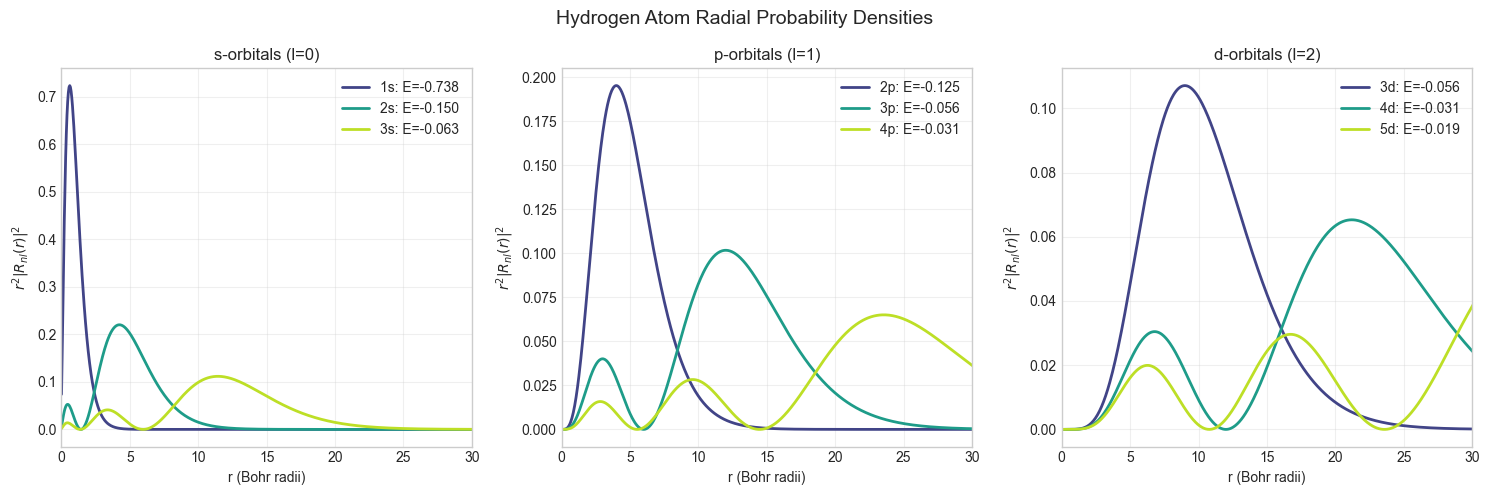

In [8]:
# ============================================================
# PLOT RADIAL PROBABILITY DENSITIES
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, l in enumerate([0, 1, 2]):
    ax = axes[idx]
    u = results[l]['u']
    E = results[l]['energies']
    
    n_show = min(3, u.shape[1])
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, n_show))
    
    for i in range(n_show):
        n = i + l + 1
        # |u(r)|² = r²|R(r)|² is the radial probability density
        prob = np.abs(u[:, i])**2
        ax.plot(r, prob, color=colors[i], lw=2, 
                label=f'{n}{orbital_names[l]}: E={E[i]:.3f}')
    
    ax.set_xlabel('r (Bohr radii)')
    ax.set_ylabel(r'$r^2|R_{nl}(r)|^2$')
    ax.set_title(f'{orbital_names[l]}-orbitals (l={l})')
    ax.set_xlim(0, 30)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Hydrogen Atom Radial Probability Densities', fontsize=14)
plt.tight_layout()
plt.savefig('hydrogen_radial.png', dpi=150)
plt.show()

In [9]:
# Print summary table
print("="*60)
print("HYDROGEN ATOM ENERGY LEVELS")
print("="*60)
print(f"{'State':^8} {'n':^5} {'l':^5} {'Numerical':^12} {'Exact':^12}")
print("-"*60)

for state, n, l, idx in [('1s',1,0,0), ('2s',2,0,1), ('2p',2,1,0),
                          ('3s',3,0,2), ('3p',3,1,1), ('3d',3,2,0)]:
    if idx < len(results[l]['energies']):
        E_num = results[l]['energies'][idx]
        E_exact = -0.5 / n**2
        print(f"{state:^8} {n:^5} {l:^5} {E_num:^12.4f} {E_exact:^12.4f}")

print("="*60)
print(f"\nGround state (1s): {results[0]['energies'][0]*27.2:.1f} eV (exact: -13.6 eV)")

HYDROGEN ATOM ENERGY LEVELS
 State     n     l    Numerical      Exact    
------------------------------------------------------------
   1s      1     0     -0.7382      -0.5000   
   2s      2     0     -0.1501      -0.1250   
   2p      2     1     -0.1250      -0.1250   
   3s      3     0     -0.0626      -0.0556   
   3p      3     1     -0.0556      -0.0556   
   3d      3     2     -0.0556      -0.0556   

Ground state (1s): -20.1 eV (exact: -13.6 eV)


## Key Insights

1. **Node counting**: The n-th state has (n-l-1) radial nodes
2. **Centrifugal barrier**: Higher l pushes probability away from nucleus
3. **Energy levels**: $E_n = -13.6/n^2$ eV — only depends on n (degeneracy!)
4. **Most probable radius**: Peak of $r^2|R|^2$ gives most likely electron position

## Project Complete! 🎉

We've covered the Schrödinger equation from basics to hydrogen atom!